In [1]:
%reload_ext autoreload
%autoreload 2

# Mahakala

In [2]:
import mahakala as ma
import numpy as np
import matplotlib.pyplot as plt

## Geodesic trajectories
example demo showing the geodesic trajectories for a non-spinning black hole

In [3]:
bhspin  = 0.0  # the spin of the black hole, this works best for zero spin
lim     = 15   # the maximum impact parameter of photons in this example
spacing = 60   # the spacing between photon impact parameters

# initialize the photons along the equator
s0 = ma.initialize_geodesics_at_camera(bhspin,60,1000,-lim,lim,spacing,camera_type='Equator')

In [4]:
# run the geodesic integrator
S, final_dt = ma.geodesic_integrator(10000, s0, 40, 1e-4, bhspin)
print(S.shape)  # (max) number of steps along geodesic, number of geodesics, 4 positions + 4 momenta

(819, 60, 8)


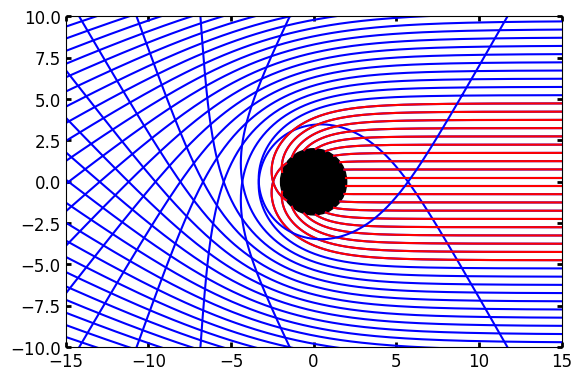

In [5]:
# make the plot of the geodesic trajectories, red photons fall into BH

ax1 = plt.subplot(1, 1, 1)

for i in range(np.shape(S)[1]):
    x = S[:, i, 1]
    y = S[:, i, 2]
    ax1.plot(x, y, c='blue')
    if np.min(np.sqrt(x*x + y*y)) < 2.01:
        ax1.plot(x, y, c='red')

circ1 = plt.Circle((0,0), radius=2, color='k', fill=True)
ax1.add_patch(circ1)

ax1.set_xlim([-lim, lim])
ax1.set_ylim([-lim/1.5, lim/1.5])
ax1.set_aspect('equal')
ax1.tick_params(axis='both', which='both', labelsize=12, width=2, direction='in', right=True, top=True, color='k') 

## Shadows
example demo of generating a few Kerr shadows for different inclinations and spins

In [6]:
num_angles = 90
bhspin  = 0.95
inc     = 90.
angles, radii = ma.find_shadow_bisection(bhspin, inc, num_angles)

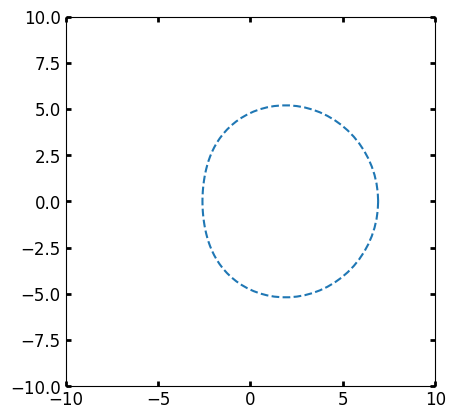

In [7]:
ax = plt.subplot(1, 1, 1)
ax.plot(radii*np.cos(angles), radii*np.sin(angles), '--', zorder=42)
lim = 10
ax.set_ylim([-lim, lim])
ax.set_xlim([-lim, lim])
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', labelsize=12, width=2, direction='in', right=True, top=True) 

(-13.0, 13.0)

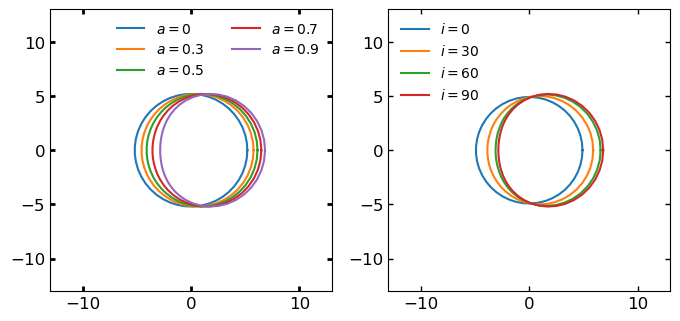

In [26]:
lim = 13
num_angles = 45
inc = 90

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(8,6)

for a in [0,.3,.5,.7,.9]:
    phi, radii = ma.bisection_shadow_par(a, inc, num_angles)
    x = radii*np.cos(phi)
    y = radii*np.sin(phi)
    ax1.plot(x,y, label = r'$a=$'+str(a))
ax1.legend(frameon=False, ncol=2)
ax1.set_aspect('equal')
ax1.tick_params(axis='both', which='both', labelsize=12,width=2,direction='in', right=True, top=True,color='k') 
ax1.set_xlim([-lim,lim])
ax1.set_ylim([-lim,lim])

for inc in [0,30,60,90]:
    phi, radii = ma.bisection_shadow_par(a, inc, num_angles)
    x = radii*np.cos(phi)
    y = radii*np.sin(phi)
    ax2.plot(x,y, label = r'$i=$'+str(inc))
ax2.legend(frameon=False)
ax2.set_aspect('equal')
ax2.tick_params(axis='both', which='both', labelsize=12,width=1,direction='in', right=True, top=True,color='k') 
ax2.set_xlim([-lim,lim])
ax2.set_ylim([-lim,lim])

## Analytic Accretion Model
example demo of generating an image of an accretion flow based on an analytic accretion model

In [ ]:
# Take in initial parameters, camera position, and parameters

grid_photons = make_grid_photons(inclination_angle, spin, distance)

my_geodesics = geodesics(grid_photons, inclination_angle, spin, distance)

fluid = get_fluid_grid(GRMHD or analytic?)

image = synemiss(my_geodesics, R_high, R_low, Mscale, fluid, ...)

## Simulation Image
example demo of generating an image based on an example GRMHD snapshot

In [ ]:
s0_x, s0_v = get_camera_pixel(90, 1000, np.ones(2)*6., np.ones(2)*0.)
init_one   = initial_condition(s0_x, s0_v, bhspin)
S,final_dt = ma.geodesic_integrator(N_time_steps,init_one,40,1e-2, bhspin)

r = radius_cal(S[:, 0], bhspin)

x = S[:, 0, 1]
y = S[:, 0, 2]
z = S[:, 0, 3]

ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

ax2.plot(r)
ax2.set_ylim(1, 2)
ax2.axhline(y=1. + np.sqrt(1.-bhspin*bhspin), ls='--', color='k')

ax1.plot(x, y)
plim = 10
ax1.set_xlim(-plim, plim)
ax1.set_ylim(-plim, plim)

In [ ]:
plt.plot(x, y)
plim = 5
plt.xlim(-plim, plim)
plt.ylim(-plim, plim)
plt.gca().set_aspect('equal')